Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
11648/11648 ━━━━━━━━━━━━━━━━━━━━ 154s 13ms/step - loss: 0.0031
Epoch 2/3
11648/11648 ━━━━━━━━━━━━━━━━━━━━ 200s 13ms/step - loss: 0.0013
Epoch 3/3
11648/11648 ━━━━━━━━━━━━━━━━━━━━ 203s 13ms/step - loss: 0.0012
364/364 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


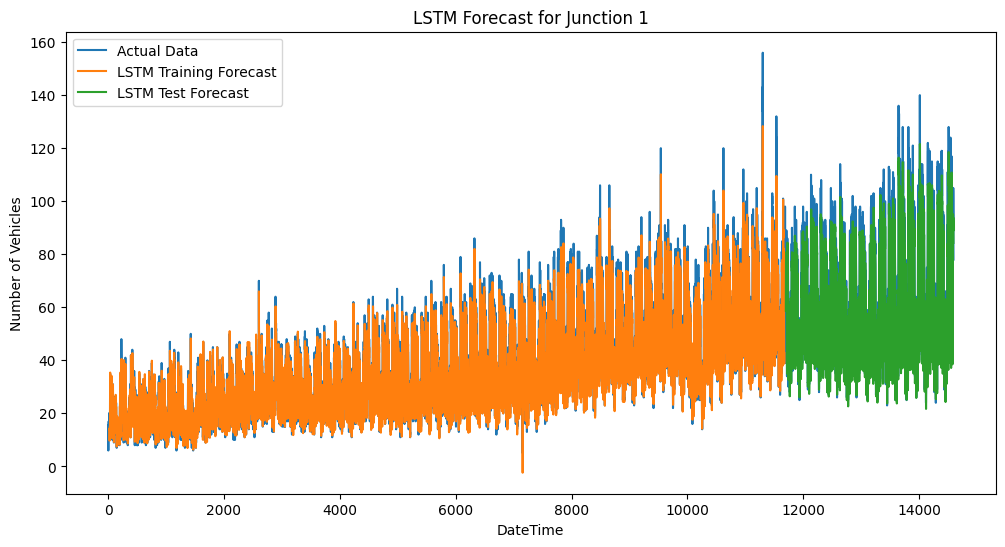

Train MSE: 23.41145756590342
Train MAE: 3.4422231591255454
Train R²: 0.9364970565859717
Train MAPE: 0.09557237103475501
Test MSE: 48.04785350573741
Test MAE: 5.128241112583161
Test R²: 0.9142062811828815
Test MAPE: 0.07666987123900428


In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/traffic.csv')

df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')

df.set_index('DateTime', inplace=True)

junction = 1
df_junction = df[df['Junction'] == junction]['Vehicles']

scaler = MinMaxScaler(feature_range=(0, 1))
df_junction_scaled = scaler.fit_transform(df_junction.values.reshape(-1, 1))

train_size = int(len(df_junction_scaled) * 0.8)
train, test = df_junction_scaled[:train_size], df_junction_scaled[train_size:]

def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 24
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=1, epochs=3)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

train_predict_plot = np.empty_like(df_junction_scaled)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

test_predict_plot = np.empty_like(df_junction_scaled)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1:len(df_junction_scaled) - 1, :] = test_predict

plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(df_junction_scaled), label='Actual Data')
plt.plot(train_predict_plot, label='LSTM Training Forecast')
plt.plot(test_predict_plot, label='LSTM Test Forecast')
plt.title('LSTM Forecast for Junction 1')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

train_mse = mean_squared_error(y_train[0], train_predict)
train_mae = mean_absolute_error(y_train[0], train_predict)
test_mse = mean_squared_error(y_test[0], test_predict)
test_mae = mean_absolute_error(y_test[0], test_predict)

# Calculate R² score and MAPE for additional accuracy evaluation
train_r2 = r2_score(y_train[0], train_predict)
test_r2 = r2_score(y_test[0], test_predict)
train_mape = mean_absolute_percentage_error(y_train[0], train_predict)
test_mape = mean_absolute_percentage_error(y_test[0], test_predict)

print(f'Train MSE: {train_mse}')
print(f'Train MAE: {train_mae}')
print(f'Train R²: {train_r2}')
print(f'Train MAPE: {train_mape}')
print(f'Test MSE: {test_mse}')
print(f'Test MAE: {test_mae}')
print(f'Test R²: {test_r2}')
print(f'Test MAPE: {test_mape}')